## BERT Emotions

In [ ]:
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Improting dataset and printing details

In [ ]:
from datasets import load_dataset

# Load Emotion dataset
dataset = load_dataset("emotion")

# View dataset structure
print(dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


## Using the tokenizer

In [ ]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename label column for clarity
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Split dataset
train_data = tokenized_datasets["train"]
test_data = tokenized_datasets["test"]
val_data = tokenized_datasets["validation"]


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Setting up Pytorch format

In [ ]:
from torch.utils.data import DataLoader

# Ensure dataset is in PyTorch format
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)
test_loader = DataLoader(test_data, batch_size=16)


## Importing Bert model

In [ ]:
from transformers import BertForSequenceClassification

# Load BERT model with the appropriate number of labels
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setting the model parameters

In [ ]:
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Use CrossEntropyLoss as the loss function
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Function

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, axis=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().tolist())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return total_loss / len(train_loader), accuracy, precision, recall, f1


## Evaluate function

In [ ]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, axis=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return total_loss / len(val_loader), accuracy, precision, recall, f1



## Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_acc, train_prec, train_rec, train_f1 = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_model(model, val_loader, criterion, device)
    print(" ")
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1 Score: {val_f1:.4f}")


Epoch 1/3


Validation: 100%|██████████| 125/125 [00:13<00:00,  8.94it/s]


 
Training Loss: 0.0745, Accuracy: 0.9704, Precision: 0.9704, Recall: 0.9704, F1 Score: 0.9704
Validation Loss: 0.1869, Accuracy: 0.9325, Precision: 0.9355, Recall: 0.9325, F1 Score: 0.9326
Epoch 2/3


Validation: 100%|██████████| 125/125 [00:14<00:00,  8.87it/s]


 
Training Loss: 0.0633, Accuracy: 0.9774, Precision: 0.9774, Recall: 0.9774, F1 Score: 0.9774
Validation Loss: 0.2081, Accuracy: 0.9395, Precision: 0.9393, Recall: 0.9395, F1 Score: 0.9392
Epoch 3/3


Validation: 100%|██████████| 125/125 [00:14<00:00,  8.88it/s]

 
Training Loss: 0.0424, Accuracy: 0.9866, Precision: 0.9866, Recall: 0.9866, F1 Score: 0.9866
Validation Loss: 0.2425, Accuracy: 0.9355, Precision: 0.9354, Recall: 0.9355, F1 Score: 0.9353


## Testing function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Predictions
            preds = torch.argmax(outputs.logits, axis=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    test_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Return metrics
    return {
        "Test Loss": test_loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [ ]:
# Assuming the test_loader, model, and criterion are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Test the model
test_metrics = test_model(model, test_loader, criterion, device)

# Print metrics
for metric, value in test_metrics.items():
    print("  ")
    print(f"{metric}: {value:.4f}")


Testing: 100%|██████████| 125/125 [00:13<00:00,  9.01it/s]

  
Test Loss: 0.2635
  
Accuracy: 0.9310
  
Precision: 0.9318
  
Recall: 0.9310
  
F1 Score: 0.9312


## Saving the model

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import BertTokenizer

# Directory to save the model
save_directory = "/content/drive/MyDrive/Models/Emotions/bert_model"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer (if used)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # Use your specific tokenizer if different
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to /content/drive/MyDrive/Models/Emotions/bert_model


## Generating Confusion matrix

Generating Predictions : 100%|██████████| 125/125 [00:14<00:00,  8.74it/s]


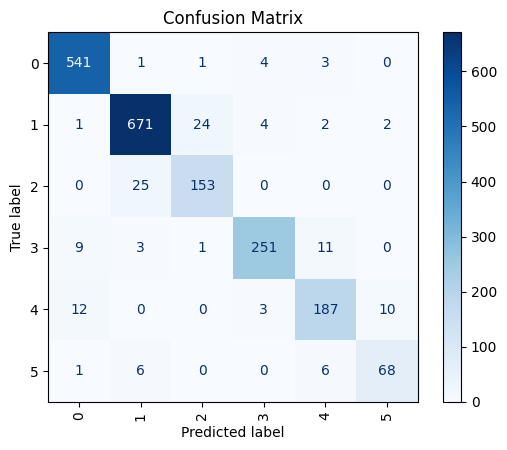

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_and_plot_confusion_matrix(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Generating Predictions "):
            inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
            labels = batch["labels"].cpu().tolist()
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, axis=1).cpu().tolist()

            all_labels.extend(labels)
            all_preds.extend(preds)

    print("  ")
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label)

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on validation data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate_and_plot_confusion_matrix(model, val_loader, device)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def plot_auc_roc(model, test_loader, device, num_classes, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating AUC-ROC Data"):
            inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
            labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).cpu().numpy()

            all_probs.extend(probs)
            all_labels.extend(labels)

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Plot the ROC Curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



## Generating the AUC-ROC Curve

Generating AUC-ROC Data: 100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


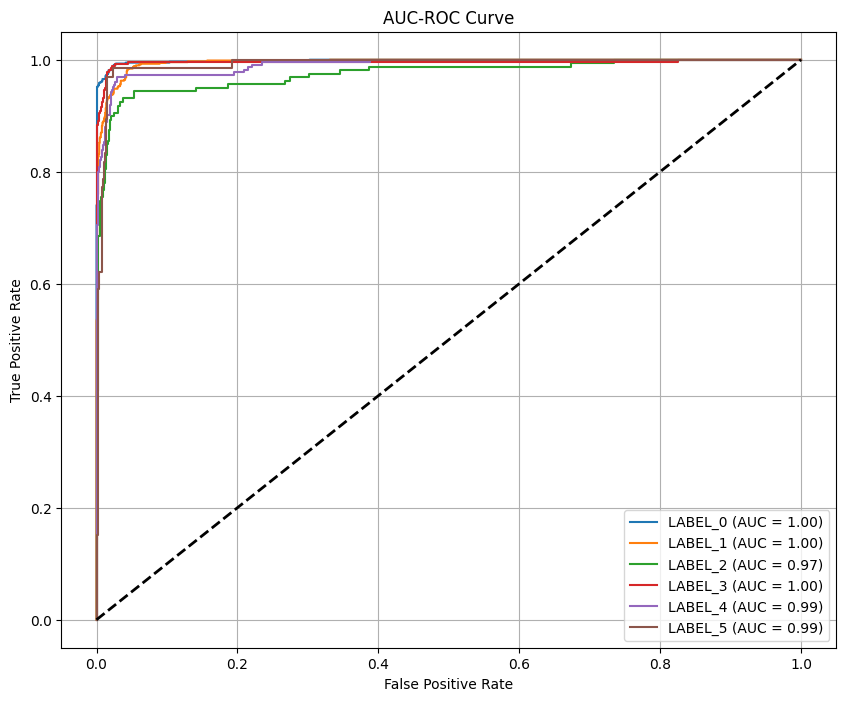

In [ ]:
# Assuming the test_loader, model, and device are already defined
class_names = [model.config.id2label[i] for i in range(len(model.config.id2label))]  # Retrieve class names
num_classes = len(class_names)  # Number of classes

# Plot AUC-ROC
plot_auc_roc(model, test_loader, device, num_classes, class_names)
